# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-10$ and $10$ N.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = model.constrain(U).detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, on_iteration=on_iteration)

iteration 1 accepted 6608.1016 [ 3.3956296  3.3629608 -1.8535357 -6.007329 ]
iteration 2 accepted 3407.9043 [ 0.36489883 -0.20423955  1.6913698   5.562053  ]
iteration 3 accepted 186.25761 [-0.40185553 -0.9011822  -0.38308978  0.09442806]
iteration 4 accepted 178.95972 [-0.36514774 -0.8091701  -0.45191967 -0.25205278]
iteration 5 FAILED 178.95972 [-0.36514774 -0.8091701  -0.45191967 -0.25205278]
iteration 6 FAILED 178.95972 [-0.36514774 -0.8091701  -0.45191967 -0.25205278]
iteration 7 FAILED 178.95972 [-0.36514774 -0.8091701  -0.45191967 -0.25205278]
iteration 8 FAILED 178.95972 [-0.36514774 -0.8091701  -0.45191967 -0.25205278]
iteration 9 accepted 111.676285 [-0.12641531  0.76341224 -0.00850609  0.15860868]
iteration 10 accepted 90.16241 [0.13837484 0.65951693 0.02753289 0.15519714]
iteration 11 FAILED 90.16241 [0.13837484 0.65951693 0.02753289 0.15519714]
iteration 12 accepted 87.88465 [ 0.12243246  0.6425311  -0.06955104 -0.16401613]
iteration 13 accepted 76.36546 [ 0.10200745  0.58

iteration 103 FAILED 33.656586 [-0.03430518  0.01132295 -0.03379749  0.0095008 ]
iteration 104 FAILED 33.656586 [-0.03430518  0.01132295 -0.03379749  0.0095008 ]
iteration 105 FAILED 33.656586 [-0.03430518  0.01132295 -0.03379749  0.0095008 ]
iteration 106 accepted 33.47761 [-0.02114916  0.01410034 -0.02989317  0.00993234]
iteration 107 accepted 33.32878 [-0.01792197  0.01107404 -0.02401104  0.00755638]
iteration 108 accepted 33.21141 [-0.0157732   0.01005483 -0.02104381  0.00699633]
iteration 109 accepted 33.05417 [-0.00753296  0.00953248 -0.01598325  0.00654942]
iteration 110 accepted 32.864014 [-0.01668862  0.0098927  -0.02156923  0.0068019 ]
iteration 111 accepted 32.7544 [-0.02783803  0.01005813 -0.02817014  0.00713432]
iteration 112 FAILED 32.7544 [-0.02783803  0.01005813 -0.02817014  0.00713432]
iteration 113 FAILED 32.7544 [-0.02783803  0.01005813 -0.02817014  0.00713432]
iteration 114 FAILED 32.7544 [-0.02783803  0.01005813 -0.02817014  0.00713432]
iteration 115 FAILED 32.7544

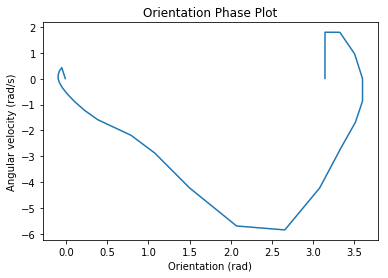

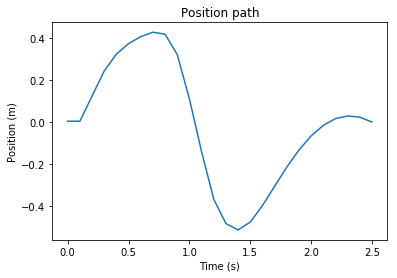

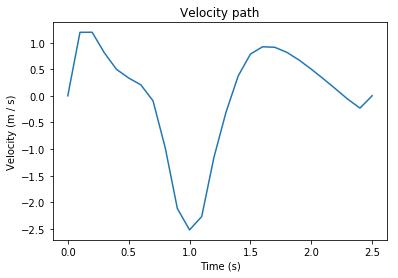

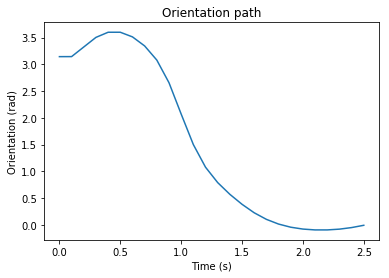

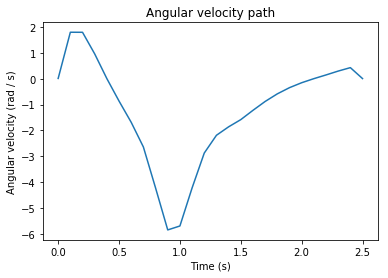

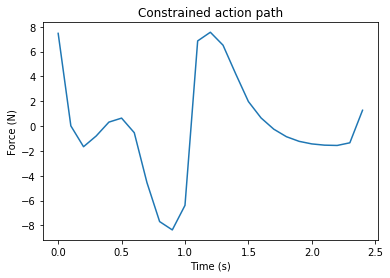

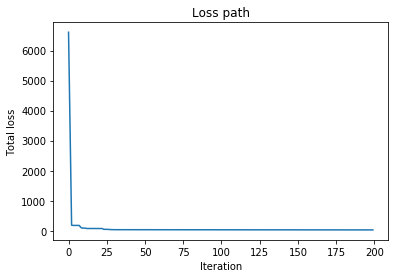

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
import time

for u in U:
    env.apply(u)
    time.sleep(DT)

In [16]:
env.close()